<a href="https://colab.research.google.com/github/duyqu-chan/Image-Preprocessing/blob/master/PCA_Augment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fancy PCA Data Augmentation

Fancy PCA uses eigenvalues and eigenvectors from Principal Component Analysis to augment an image while maintaining the features and detail of the image. Following the work of [Alex Krizhevsky et al.](https://www.nvidia.cn/content/tesla/pdf/machine-learning/imagenet-classification-with-deep-convolutional-nn.pdf) we will alter the intensities of the RGB channels as follows:
+ PCA will be performed on the set of RGB pixel values throughout the training set. 
+ To each training image, we will add multiples of the found principal components, with magnitudes proportional to the corresponding eigenvalues times a random variable drawn from a Gaussian with mean zero and standard deviation 0.1.

In [0]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


Read filenames in the train set and append to a list

In [0]:
from PIL import Image
import glob
import cv2

def readNames(path):
  "A function for reading image names (jpg) given a path and appending to a list"
  fullPath = path + "/*.jpg"
  imnames = []
  for filename in glob.glob(fullPath):
    imnames.append(filename)
  return imnames
path = "/content/drive/My Drive/Dataset/Images"
imnames = readNames(path) #
len(imnames)

81

Read collection of images with imread_collection

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io,transform
# Read collection of images with imread_collection
imlist = (io.imread_collection(imnames)) #

Transform all the images to a standard so there is no inconsistency in size.

In [0]:
def resize_img(imlist, w = 1536, h = 1024):
  for i in range(len(imlist)):
    # Using the skimage.transform function-- resize image (m x n x dim).
	  m = transform.resize(imlist[i],(w,h,3))
  return m
m = resize_img(imlist, w = 1536, h = 1024)

Turn the image matrix of m x n x 3 to lists of rgb values i.e. (m*n) x 3.

In [0]:
def reshape_img(m, w=1536, h=1024):
  # initializing with zeros.
  res = np.zeros(shape=(1,3))

  for i in range(len(imlist)):
    m = transform.resize(imlist[i],(w,h,3))
	  # Reshape the matrix to a list of rgb values.
    arr=m.reshape((w*h),3)
	  # concatenate the vectors for every image with the existing list.
    res = np.concatenate((res,arr),axis=0)

    # delete initial zeros' row
    res = np.delete(res, (0), axis=0)
    # return list of vectors - 3 columns (rgb)
  
  return res

res = reshape_img(m)

 For PCA to work properly, subtract the mean from each of the dimensions.

In [0]:
m = res.mean(axis = 0)
res = res - m

Calculate the covariance matrix

In [0]:
R = np.cov(res, rowvar=False)
R

array([[0.10331572, 0.05178101, 0.01420934],
       [0.05178101, 0.0285247 , 0.00945998],
       [0.01420934, 0.00945998, 0.00753794]])

 Calculate the Eigenvectors and Eigenvalues of the covariance matrix.  The eigenvector with the highest value is also the principal component of the dataset. 

In [0]:
from numpy import linalg as LA

evals, evecs = LA.eigh(R)
idx = np.argsort(evals)[::-1] #eigenvalues are sorted
evecs = evecs[:,idx] #eigenvectors are sorted from highest to lowes

# sort eigenvectors according to same index
evals = evals[idx]

# select the best 3 eigenvectors (3 is desired dimension
# of rescaled data array)
evecs = evecs[:, :3]

# make a matrix with the three eigenvectors as its columns.
evecs_mat = np.column_stack((evecs))

Performing PCA transformation

In [0]:
# carry out the transformation on the data using eigenvectors
# and return the re-scaled data, eigenvalues, and eigenvectors
m = np.dot(evecs.T, res.T).T

Augmentation

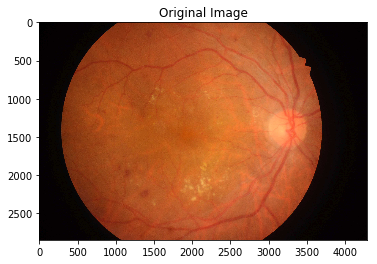

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


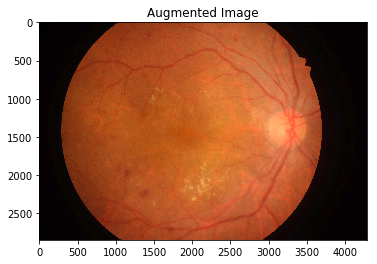

In [0]:
def data_aug(img,evecs_mat,evals):
    mu = 0
    sigma = 0.1
    feature_vec=np.matrix(evecs_mat)

	  # 3 x 1 scaled eigenvalue matrix
    se = np.zeros((3,1))
    se[0][0] = np.random.normal(mu, sigma)*evals[0]
    se[1][0] = np.random.normal(mu, sigma)*evals[1]
    se[2][0] = np.random.normal(mu, sigma)*evals[2]
    se = np.matrix(se)
    val = feature_vec*se
    # Parse through every pixel value.
    for i in range(img.shape[0]):
      for j in range(img.shape[1]):
        # Parse through every dimension.
        for k in range(img.shape[2]):
          img[i,j,k] = float(img[i,j,k]) + float(val[k])
    
    return img
# Calling function for first image.
# Re-scaling from 0-255 to 0-1.
img = imlist[0]/255.0
plt.figure()
plt.imshow(img)
plt.title("Original Image")
plt.show()
img_new =data_aug(img,evecs_mat,evals)
plt.figure()
plt.imshow(img_new)
plt.title("Augmented Image")
plt.show()

In [0]:
np.sum(img == img_new)

36636672

Alltogether

In [0]:
path = "/content/drive/My Drive/Dataset/Images" #define path
imnames = readNames(path) #read image names and store in a list ***
imlist = (io.imread_collection(imnames)) #read images as a collection
w = 1536
h = 1024
m = resize_img(imlist, w, h) #resize images ***
res = reshape_img(m) #reshape images to ((w,h),3) ***
m = res.mean(axis = 0)#calculate mean
res = res - m #subtract mean
R = np.cov(res, rowvar=False) #calculate covariance matrix of ALL images!
evals, evecs = LA.eigh(R) #calculate eigenvalues and eigenvectors
idx = np.argsort(evals)[::-1] #eigenvalues are sorted from highest to lowest
evecs = evecs[:,idx] 
evals = evals[idx] # eigenvectors are sorted according to their eigenvalue
evecs = evecs[:, :3] # select the best 3 eigenvectors (3 is desired dimension of rescaled data array)
evecs_mat = np.column_stack((evecs)) # make a matrix with the three eigenvectors as its columns.
m = np.dot(evecs.T, res.T).T #PCA transformation is performed
img = imlist[0]/255.0 #choose a image from the list
img_new =data_aug(img,evecs_mat,evals) #augment it